In [2]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

Current venv: C:\Users\LukasGrahl\Documents\GIT\memoire1\env_macro_rbc
DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.filtering_sampling import solve_updated_mod

import numpy as np
import pandas as pd

import os
from itertools import chain

from config import plt_config
plt.rcParams.update(plt_config)

globals 

In [4]:
plot_vars = ['Y', 'O', 'A', 'C', 'I', 'L', 'w', 'r', 'pi', 'lambda']

load model

In [5]:
mod = gEconModel(os.path.join(MODEL_DIR, f'mod6_nk_energy_lin2.gcn'), verbose=True)

Model Building Complete.
Found:
	7 equations
	7 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	10 parameters
		 0 / 10 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
mod.free_param_dict

{'M': 3.0,
 'X': 0.03,
 'alpha_m': 0.4,
 'alpha_n': 0.4,
 'beta': 0.995,
 'epsilon': 1.0,
 'gamma': 0.1,
 'phi_pi': 1.1,
 'rho_s': 0.9,
 'theta': 0.75}

In [43]:
mod.variables

[CPI_t, C_t, S_t, Y_t, i_t, pi_t, r_t]

In [44]:
mod.steady_state(model_is_linear=True)

Steady state found! Sum of squared residuals is 0.0


In [45]:
mod.solve_model(model_is_linear=True)

Solution found, sum of squared residuals:  7.730857881701882e-33
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [31]:
solve_updated_mod(mod, verbose=True, model_is_linear=True)

Steady state found! Sum of squared residuals is 0.0
Solution found, sum of squared residuals:  1.020116798100995e-33


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
mod.variables

In [14]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors
mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'is_lin': False},
    # 'mod5_nk_vanilla': {'params': mod5_params,
    #                     'priors': mod5_priors,
                        # 'is_lin': False},    
    'mod6_nk_energy_lin2': {'params': mod5_params,
                                   'is_lin': True,
                                   'priors': mod5_priors},
}

# load model
for key in mods.keys():
    # load
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=False)
    
    # solve
    _, mods[key]['mod'] = solve_updated_mod(mods[key]['mod'], verbose=True, model_is_linear=mods[key]['is_lin'])
    assert _ == True
    
    # get shocks
    mods[key]['shocks'] = [item.base_name for item in mods[key]['mod'].shocks]

Steady state found! Sum of squared residuals is 0.0
Solution found, sum of squared residuals:  7.706121454077136e-34
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


In [15]:
mods[key]['mod'].variables

[i_t, pi_q_t, r_t, s_t, y_t]

### IRF

In [11]:
shock_size = -.1
sim_length = 120

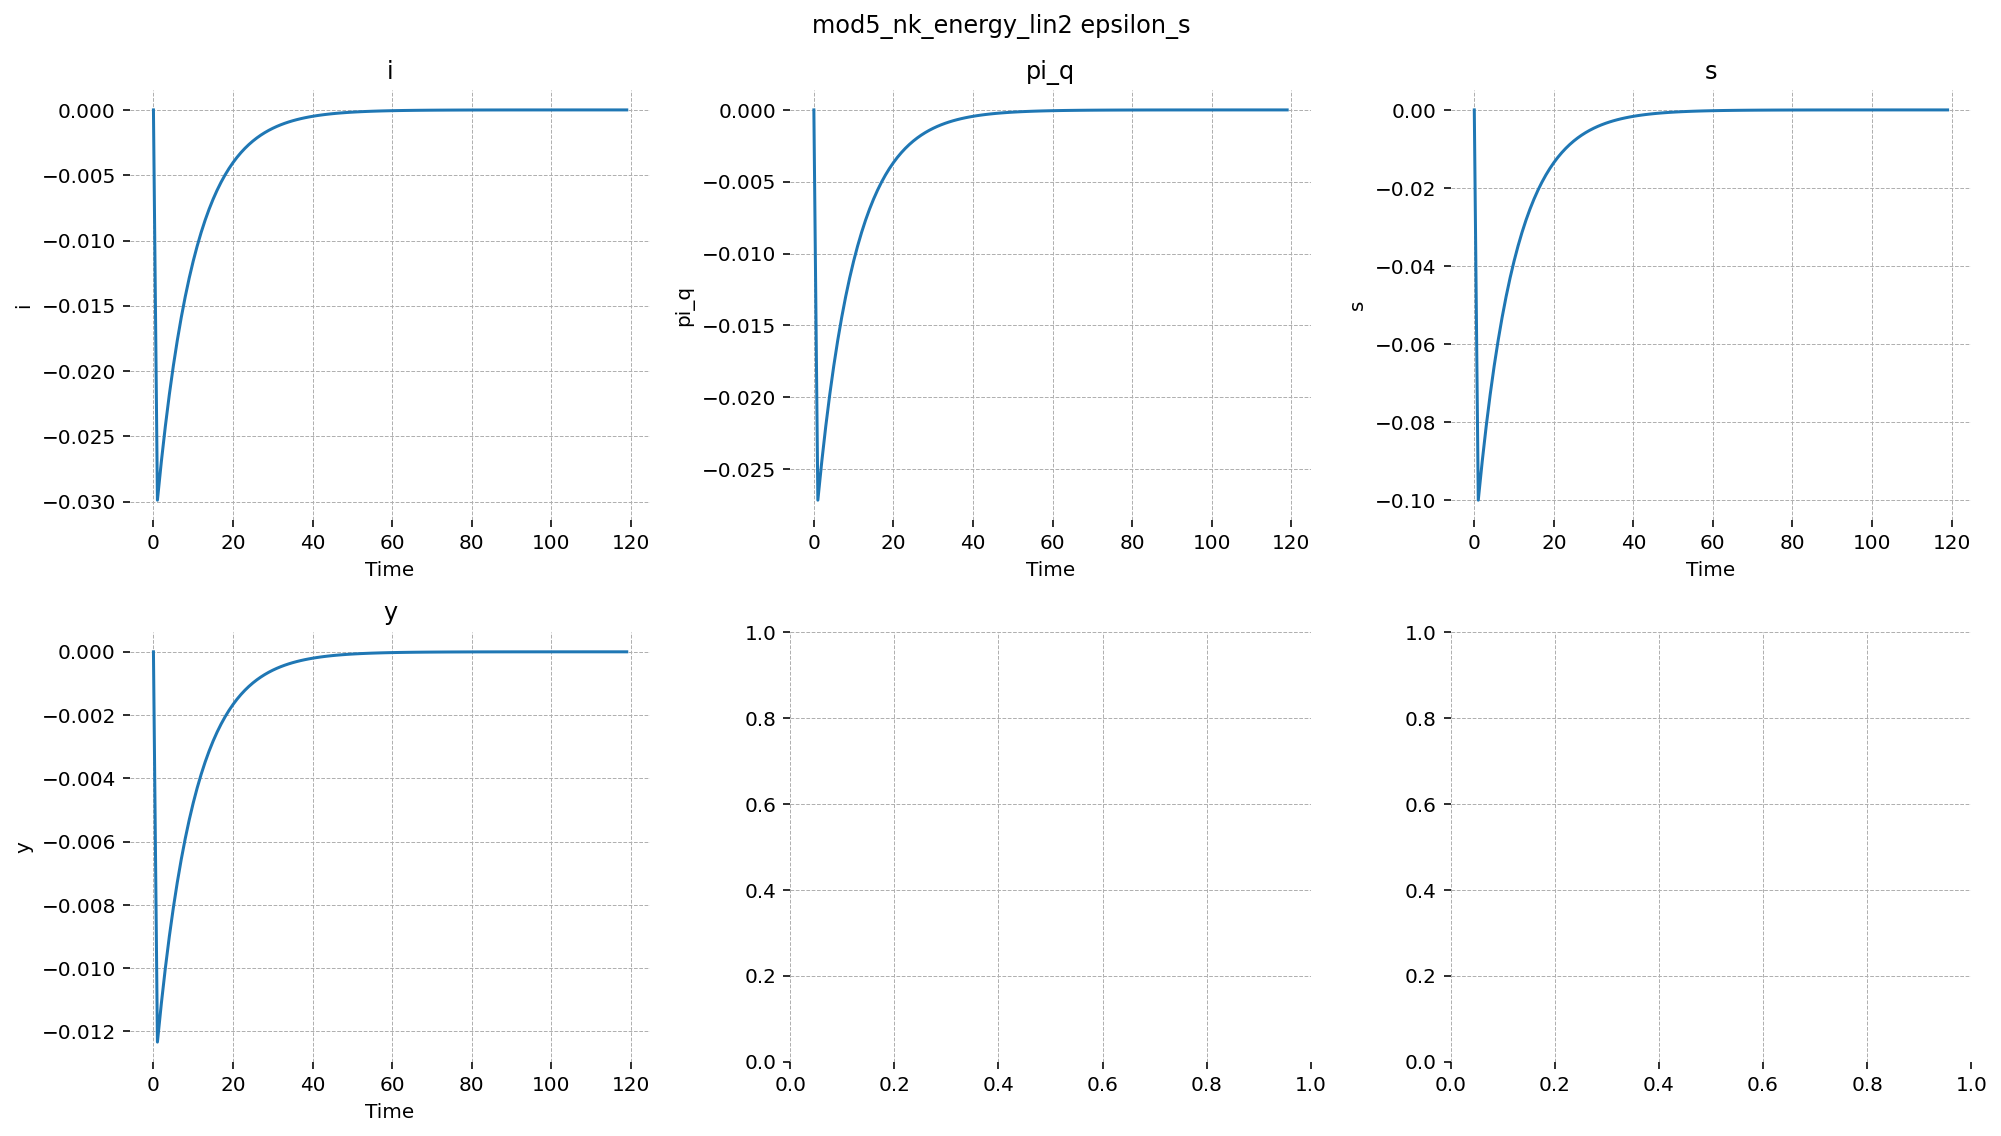

In [9]:
for key in mods.keys():
    # get irfs
    mods[key]['irf'] = mods[key]['mod'].impulse_response_function(simulation_length=sim_length, shock_size=shock_size)
    
    # plot irf per shock
    for shock in mods[key]['shocks']:
        plot_dfs(mods[key]['irf'].unstack().loc[:, shock].unstack(), sns.lineplot, fig_title=f'{key} {shock}')